## TD METHODS

In DP methods we found optimal policies. But, we used ```transition_map``` to do that. This is quite impractical. There are many reasons for that:

- We don't know all the states we can visit
- Environment dynamics can be unknown
- Iterating over all states can be computationally infeasible

In this notebook, we will be practicing over TD methods. Instead of calculating exact value we will get samples and estimate the value over samples. One thing comes into mind when we talk about the sample is **Monte Carlo**. MC method is the first algorithm we will be implementing.

**MC** estimation and control is pretty simple. We sample trajectories from the environment by following a policy $\pi$ and calculate the returns of each state we visit.

**Question 1)** How can you ensure that we visit(sample) enough states to find an optimal policy?

We can use epsilon-greedy approach for taking actions in order to solve exploration-exploitation dilemma. This way, we will get a chance to observe unobserved states.

#### Environment

We will be using a new environment called **Warehouse** where an agent tries to match each item with the corresponding box. Building a transition map for this environment would be painful. Luckily, we don't need to build that in TD methods. The ```worldmap``` is given below (you can modify this for fun but, we will be using the one below to evaluate).

You can run the cell below to visualize the environment.
- <span style="color:#989898">Dark gray cells</span> are impassable cells.
- <span style="color:#DADADA">light gray cells</span> are passable empty cells.
- <span style="color:#00B8FA">Blue cell</span> is the agent.
- <span style="color:#A33675"> cell </span> and <span style="color:#48C69F"> cell </span> are items to collect. 
- <span style="color:#B34685"> cell </span> and <span style="color:#58D6AF"> cell </span> are the boxes.

Note that, boxes are slightly lighter in color.

Pairing is also given below. A key in the pairing dictionary is a box(uppercase) and its corresponding value is a list of items(lowercase) that can be delivered to that box.

State representation is different here. Instead of giving just the position of the agent, we have 4 more additional features. These are 4 boolean values for two items and two boxes.  The boolean feature is true if the item or box exists on the map and false otherwise.

In [1]:
%load_ext autoreload
%autoreload 2

from rl_hw1.env import Warehouse

worldmap = ["#########",
            "#   #   #",
            "# c # C #",
            "#   #   #",
            "#   P   #",
            "#   #   #",
            "# b # B #",
            "#   #   #",
            "#########"]

# Buckets are Uppercase letters while balls are lowercase
# Matching is done so that the ball "b" must be carried to the bucket "B"
pairing = {
    "B": ["b"],
    "C": ["c"]
}

env = Warehouse(balls="cb", buckets="BC",
                pairing=pairing, worldmap=worldmap)
env.init_render()


/home/nlztrk/anaconda3/envs/drl/lib/python3.6/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


Canvas(layout=Layout(height='500px', width='700px'), size=(700, 500))

**Question 2)** In the ```rl_hw1/learning/monte_carlo.py``` module, implement ```MonteCarloAgent```



Let's train the ```MonteCarloAgent``` using the training loop given below. You can tune hyperparameters(```args```) given below. ```args``` is a namedtuple built from the dictionary initialized between lines 10 and 18. 

**Question 3)** Train the ```MonteCarloAgent``` by tuning the hyperparameters. For all of your implementations (MC, Q learning, Sarsa) your agent should get at least **1.5** episodic reward(sum of rewards throughout an episode).

In [2]:
from rl_hw1.learning import MonteCarloAgent
from collections import namedtuple
import numpy as np
import random

# Initialize agent
agent = MonteCarloAgent(nact=4)

# Hyperparameters
args = dict(
    iteration = 850, #3000
    gamma = 0.98,
    alpha = 0.1,
    init_eps = 0.75,
    final_eps = 0.15,
    eps_decay_rate = 0.998,
    seed = 12020,            # Current year: (10000 + 2020 = 12020) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values()) 

# Seed
np.random.seed(args.seed)
random.seed(args.seed)

# Traning loop
reward_list = []
epsilon = args.init_eps
for ix in range(args.iteration):
    epsilon = max( min(args.init_eps, epsilon*args.eps_decay_rate), args.final_eps)
    reward = agent.one_epsiode_train(
        env, lambda x: agent.e_greedy_policy(x, epsilon), args.gamma, args.alpha)
    reward_list.append(reward)
    if ((ix + 1) % 50) == 0:
        print("Episode: {}, reward: {}".format(ix + 1, np.mean(reward_list[-100:])))

Episode: 50, reward: 0.0
Episode: 100, reward: 0.0
Episode: 150, reward: 0.42
Episode: 200, reward: 0.86
Episode: 250, reward: 0.44
Episode: 300, reward: 0.5
Episode: 350, reward: 1.5
Episode: 400, reward: 2.0
Episode: 450, reward: 2.0
Episode: 500, reward: 2.0
Episode: 550, reward: 2.0
Episode: 600, reward: 2.0
Episode: 650, reward: 2.0
Episode: 700, reward: 2.0
Episode: 750, reward: 2.0
Episode: 800, reward: 2.0
Episode: 850, reward: 2.0


Now, let's try to render the trained agent. Run the followwing cells below.

In [3]:
env = Warehouse(balls="cb", buckets="BC",
                pairing=pairing, worldmap=worldmap)
env.init_render()

Canvas(layout=Layout(height='500px', width='700px'), size=(700, 500))

In [4]:
# You can run this cell to visualize the agent as many times as you wish.
agent.evaluate(env, render=True)

2.0

MC method waits until the episode is terminated to begin the update. But, is it possible to update the policy within every transition? Temporal Difference(TD) methods exactly aim for this. There are two popular TD methods that you will be implementing: Q Learning and SARSA.

**Question 3)** What is the difference between off-policy and on-policy algorithms?

Off-Policy algorithms take $\textbf{greedy actions}$ based on current values. They learn the value of the optimal policy independently of the agent's actions. 

On-Policy algorithms take actions based on $\textbf{the current policy}$. They learn the value of the policy being carried out by the agent including the exploration steps.


### Q - Learning

Q learning is an off-policy algorithm that employs temporal difference value estimation.

**Question 4)** What makes Q learning an off-policy algorithm?

Because it optimizes its values by the values of the next state and $\textbf{greedy action}$.

**Question 5)**  In the ```rl_hw1/learning/td.py``` module, implement ```QAgent```

In [5]:
from collections import namedtuple
import numpy as np
import random
import matplotlib.pyplot as plt

from rl_hw1.learning import QAgent, SarsaAgent


# Initiate environment
env = Warehouse(balls="cb", buckets="BC",
                pairing=pairing, worldmap=worldmap)

# Initialize agent
q_agent = QAgent(nact=4)
# Hyperparameters
args = dict(
    episodes = 2800,
    evaluate_period = 50,
    gamma = 0.75,
    alpha = 0.1,
    init_eps = .9,
    final_eps = .2,
    eps_decay_rate = 0.9995,
    seed = 12020,            # Current year: (10000 + 2020 = 12020) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values()) 

# Seed
np.random.seed(args.seed)
random.seed(args.seed)


q_rewards = q_agent.train(env, q_agent.e_greedy_policy, args)

/home/nlztrk/anaconda3/envs/drl/lib/python3.6/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


Episode: 50, reward: 0.1
Episode: 100, reward: 0.2
Episode: 150, reward: 0.5
Episode: 200, reward: 1.0
Episode: 250, reward: 1.2
Episode: 300, reward: 1.35
Episode: 350, reward: 1.1
Episode: 400, reward: 1.2
Episode: 450, reward: 1.15
Episode: 500, reward: 1.1
Episode: 550, reward: 1.15
Episode: 600, reward: 1.3
Episode: 650, reward: 1.4
Episode: 700, reward: 1.3
Episode: 750, reward: 1.25
Episode: 800, reward: 1.1
Episode: 850, reward: 1.65
Episode: 900, reward: 1.8
Episode: 950, reward: 1.7
Episode: 1000, reward: 1.7
Episode: 1050, reward: 2.0
Episode: 1100, reward: 2.0
Episode: 1150, reward: 1.95
Episode: 1200, reward: 1.8
Episode: 1250, reward: 1.9
Episode: 1300, reward: 2.0
Episode: 1350, reward: 1.95
Episode: 1400, reward: 1.95
Episode: 1450, reward: 2.0
Episode: 1500, reward: 1.95
Episode: 1550, reward: 1.95
Episode: 1600, reward: 2.0
Episode: 1650, reward: 2.0
Episode: 1700, reward: 2.0
Episode: 1750, reward: 2.0
Episode: 1800, reward: 1.95
Episode: 1850, reward: 1.95
Episode: 

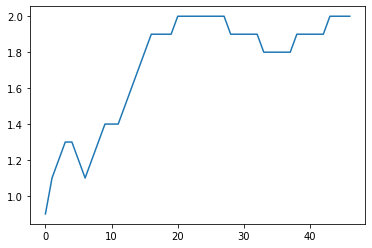

In [6]:
%matplotlib inline
plt.plot(np.convolve(q_rewards, np.ones(10)/10, "valid"))
plt.show()

In [7]:
env.init_render()

Canvas(layout=Layout(height='500px', width='700px'), size=(700, 500))

In [8]:
# You can run this cell to visualize the agent as many times as you wish.
q_agent.evaluate(env, render=True)

2.0

You implemented an off-policy TD(Temporal Difference) Learning algorithm. Now, try to implement SARSA. You can find the pseudocode in chapter 6 of Reinforcement Learning Book (Sutton & Barta).

**Question 6) What makes SARSA an on-policy algorithm?

Because it optimizes its values by the values of the next state and $\textbf{action that comes from the current policy}$. It estimates that the current policy will be continued to be used.

**Question 7)** In the ```rl_hw1/learning/td.py``` module, implement ```SarsaAgent```

**Question 8)** Write down a training loop similar to what we did for Q learning on the above cells, to test your ```SarsaAgent```

In [9]:
# Sarsa training loop

# Initialize agent
sarsa_agent = SarsaAgent(nact=4)
# Hyperparameters
args = dict(
    episodes = 1900,
    evaluate_period = 50,
    gamma = 0.75,
    alpha = 0.2,
    init_eps = .9,
    final_eps = .2,
    eps_decay_rate = 0.9995,
    seed = 12020,            # Current year: (10000 + 2020 = 12020) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values()) 

# Seed
np.random.seed(args.seed)
random.seed(args.seed)

sarsa_rewards = sarsa_agent.train(env, sarsa_agent.e_greedy_policy, args)


Episode: 50, reward: 0.1
Episode: 100, reward: 0.2
Episode: 150, reward: 0.15
Episode: 200, reward: 1.05
Episode: 250, reward: 1.3
Episode: 300, reward: 1.25
Episode: 350, reward: 1.2
Episode: 400, reward: 1.3
Episode: 450, reward: 1.15
Episode: 500, reward: 1.2
Episode: 550, reward: 1.2
Episode: 600, reward: 1.1
Episode: 650, reward: 1.15
Episode: 700, reward: 1.25
Episode: 750, reward: 1.1
Episode: 800, reward: 1.0
Episode: 850, reward: 1.2
Episode: 900, reward: 1.15
Episode: 950, reward: 1.05
Episode: 1000, reward: 1.1
Episode: 1050, reward: 1.05
Episode: 1100, reward: 1.1
Episode: 1150, reward: 1.4
Episode: 1200, reward: 1.15
Episode: 1250, reward: 1.2
Episode: 1300, reward: 1.35
Episode: 1350, reward: 1.25
Episode: 1400, reward: 1.5
Episode: 1450, reward: 1.6
Episode: 1500, reward: 1.7
Episode: 1550, reward: 1.75
Episode: 1600, reward: 1.95
Episode: 1650, reward: 2.0
Episode: 1700, reward: 1.75
Episode: 1750, reward: 1.9
Episode: 1800, reward: 2.0
Episode: 1850, reward: 2.0
Episod

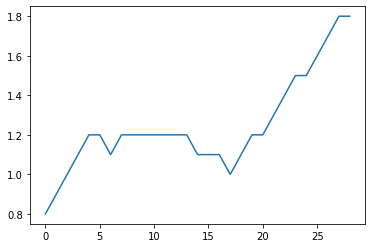

In [10]:
# Sarsa reward visaulization

%matplotlib inline
plt.plot(np.convolve(sarsa_rewards, np.ones(10)/10, "valid"))
plt.show()

In [11]:
# Sarsa visaulization
env.init_render()

Canvas(layout=Layout(height='500px', width='700px'), size=(700, 500))

In [12]:
sarsa_agent.evaluate(env, render=True)

2.0

**Question 9)** Until now, you have learned both MC and TD methods to estimate value. Can you explain in which situations these methods(TD, MC) are most suitable?

Monte Carlo methods perform
an update for each state based on the entire sequence of observed rewards from that
state until the end of the episode. The update of one-step TD methods, on the other
hand, is based on just the one next reward, bootstrapping from the value of the state
one step later as a proxy for the remaining rewards.

In MC, we optimize our values after the episode is completed. In TD, we optimize our values after each iteration. So our policy changes during the episode. If we have targeted a specific final state or reward, it would be good to go with MC. Otherwise, we should select TD methods since they have more greedy approach for tuning values in each iteration.

**Question 10)** Can you think of an algorithm that combines the advanteges of MC and TD methods. Write down a **simple**  pseudocode.

With applying the sense of n-step TD methods to the MC method, we can achieve that.

$\pi$ = initialized policy\
Initialize V(s) arbitrarily\
In $S_t$ and $R_t$ s $t$ would be in $mod(n+1)$.

$\hspace{10mm}$ Loop for each episode:\
$\hspace{20mm}$ Initialize and store $S_0$\
$\hspace{20mm}$ Loop for $t=0,1,2...$:\
$\hspace{30mm}$ if $t<T$:\
$\hspace{40mm}$ Take an action according to $\pi$\
$\hspace{40mm}$ Observe and store reward as $R_{t+1}$ and the next state $S_{t+1}$\
$\hspace{40mm}$ If $S_{t+1}$ is terminal, $T=t+1$\
$\hspace{30mm}$ $\tau = t-n+1$\
$\hspace{30mm}$ if $\tau \geq 0$:\
$\hspace{40mm}$ Calculate cumulative reward\
$\hspace{40mm}$ If $\tau + n < T$: Update cumulative reward with the addition of Value output\
$\hspace{40mm}$ Update values

#### Approximate Methods

We have seen different ways to estimate value (or return) however until now we only worked on tabular representations. But almost always states are represented with vectors. In this part of the homework, you will be working on linear representations that can work with continuous state spaces.

We can use any function to represent values as long as it returns a single scalar value for a state-action pair. For simplicity, we will be using a linear function. Function approximation methods can be used in both Sarsa and Q learning. In this homework, we will be implementing function approximation with Q learning.

You can find a similar algorithm within the pseudocode at **chapter 9.3 in Reinforcement Learning Book (Sutton & Barto)**. These methods are called **semi-gradient** methods. The reason is that we do not take the gradient of the loss term(mean squared TD) with respect to both functions $Q(s,a)$ and $\max_i Q(s', a_i)$.

Please read the relevant section

**Question 11)** In tabular settings, whenever we update the value of a particular state action pair $(s, a)$, only a single value changes. What are your thoughts about value change in approximate settings after an update?

For each transition, we are taking gradients of weights and multiply the old weights with the multiplication of TD Error, these gradients and a specific alpha parameter. This way, we updated all the weights at the same time. This means in one action, we updated all values w.r.t. to the given reward and gradient values.

In this part of the homework, we will be using the **CartPole** environment. It is a continuous state, discrete action environment. You can check it out from [Open AI gym](https://gym.openai.com/envs/CartPole-v0/) for more details.

**Question 12)** We will be using a linear function. However, we still need to have some features over raw observation. Complete the implementation of the wrapper below.

In [13]:
from gym import ObservationWrapper
from gym.spaces import Box


class FeaturedObservation(ObservationWrapper):
    """ Create feature vectors that are randomly scattered in the observation
    space. Instead of returning the raw state(observation) return features.
    The feature matrix is a KxN matrix where K denotes the number of features while N
    denotes raw state space size. Each row in the Feature matrix represents a feature
    in the state space.
    
    F(S): R^{N} -> R^{K}  
    
    Returning vector is simply a dot product between each feature vector and the
    observed state(observation).
    
    Arguments:
        - env: gym environment
        - n_features: Number of features
    """
    def __init__(self, env, n_features):
        super().__init__(env)
        self.features = np.random.uniform(
            -0.4, 0.4,
            size=(n_features, env.observation_space.shape[0]))
        _low = env.observation_space.low.min()
        _high = env.observation_space.high.max()
        _dtype = env.observation_space.dtype
        self.observation_space  = Box(low=_low,
                                      high=_high,
                                      shape=(n_features,),
                                      dtype=_dtype)

    def observation(self, observation):
        """ Return features of the obervation using matrix multiplication.
        """
        # IMPLEMENT HERE

        return np.dot(self.features, observation)

**Question 13)** In the ```rl_hw1/learning/approximate.py``` module, implement ```ApproximateAgent``` & ```ApproximateQAgent```

**Question 14)** Run the approximate q learning agent by tuning the hyperparameters (```args```) given below.

In [14]:
from collections import namedtuple
import numpy as np
import random
import gym
import matplotlib.pyplot as plt

from rl_hw1.learning import ApproximateQAgent

# Hyperparameters
args = dict(
    episodes = 65000,
    evaluate_period = 500,
    n_features = 64,
    gamma = 0.95,
    alpha = 1e-10,
    init_eps = 1,
    final_eps = 0.05,
    eps_decay_rate = 0.999965,
    seed = 12020,            # Current year: (10000 + 2020 = 12020) Holocene calendar
)
args = namedtuple('args', args.keys())(*args.values())

# Initiate environment
env = gym.make("CartPole-v1")

# Seed
env.seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

# Wrap the environment
env = FeaturedObservation(env, args.n_features)

# Initialize agent
appx_q_agent = ApproximateQAgent(
    nobs = env.observation_space.shape[0],
    nact = env.action_space.n
)
    
appx_q_rewards, appx_q_losses = appx_q_agent.train(env, appx_q_agent.e_greedy_policy, args)

/home/nlztrk/anaconda3/envs/drl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Episode: 500, reward: 21.5
Episode: 1000, reward: 24.2
Episode: 1500, reward: 24.3
Episode: 2000, reward: 33.6
Episode: 2500, reward: 25.4
Episode: 3000, reward: 32.15
Episode: 3500, reward: 27.0
Episode: 4000, reward: 28.2
Episode: 4500, reward: 30.1
Episode: 5000, reward: 35.3
Episode: 5500, reward: 22.75
Episode: 6000, reward: 36.05
Episode: 6500, reward: 34.2
Episode: 7000, reward: 35.4
Episode: 7500, reward: 39.8
Episode: 8000, reward: 44.45
Episode: 8500, reward: 41.75
Episode: 9000, reward: 35.25
Episode: 9500, reward: 53.75
Episode: 10000, reward: 53.55
Episode: 10500, reward: 33.1
Episode: 11000, reward: 47.45
Episode: 11500, reward: 61.45
Episode: 12000, reward: 35.1
Episode: 12500, reward: 72.65
Episode: 13000, reward: 52.4
Episode: 13500, reward: 65.8
Episode: 14000, reward: 66.3
Episode: 14500, reward: 59.4
Episode: 15000, reward: 48.5
Episode: 15500, reward: 59.85
Episode: 16000, reward: 59.5
Episode: 16500, reward: 56.9
Episode: 17000, reward: 78.3
Episode: 17500, reward

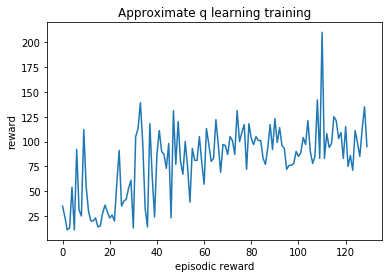

In [15]:
plt.title("Approximate q learning training")
plt.xlabel("episodic reward")
plt.ylabel("reward")
plt.plot(appx_q_rewards)

Now evaluate your agent. We expect to see at least **100** episodic reward in average.

In [16]:
# You can run this cell to visualize the agent
# If you run evaluation with render from docker it may not work!!
appx_q_agent.evaluate(env, render=True)

147.0

In [17]:
appx_q_agent_rewards = [appx_q_agent.evaluate(env, render=False) for i in range(100)]
print("Average episodic reward: {:.4}, Deviation: {:.4}".
      format(np.mean(appx_q_agent_rewards), np.std(appx_q_agent_rewards)))

Average episodic reward: 101.0, Deviation: 22.53
